<a href="https://colab.research.google.com/github/shadialameddin/tensor_decomposition/blob/master/tensor_decomposition_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://tensorly.org/stable/auto_examples/index.html#general-examples

https://github.com/tensorly/tensorly


Sparse backend

Kruskal-tensors have been renamed cp_tensors

Matrix-product-state has now been renamed tensor-train


In [ ]:
!pip install -U tensorly --quiet

In [ ]:
import os 

In [ ]:
if not os.path.exists('tensor_decomposition') and not os.path.isfile('TensorDecomp.py'):
    !git clone https://github.com/shadialameddin/tensor_decomposition.git --quiet

In [ ]:
%cd tensor_decomposition

In [1]:
from TensorDecomp import *
import matplotlib.pyplot as plt

list of available decomposition types:

decomp_list = ['svd', 'parafac', 'tucker', 'matrix_product_state', 'NMF','non_negative_parafac', 'clarkson_woodruff_transform']
#### The Error Handles

In [2]:
err_fro  = lambda  x, y : norm(x-y, ord='fro') / norm(x, ord='fro')
err_L1   = lambda  x, y : norm(x-y, ord=1) / norm(x, ord=1)
err_Linf = lambda  x, y : norm(x-y, ord=inf) / norm(x, ord=inf)
err_Spec = lambda  x, y : norm(x-y, ord=2) / norm(x, ord=2)
    
normL = [err_fro, err_L1, err_Linf, err_Spec]

### Scene Setup

In [3]:
ngp, d, N = 8192, 6, 64

# the tensor of interest 
tensor = np.random.rand(ngp, d, N)

# two derived matrices of the tensor (unfolding)
mat_repr1_tens = tensor.reshape(-1, N)
mat_repr2_tens = tensor.reshape(ngp,-1)

# a vector with appropriate dimension to perform operations
vec = np.random.rand(N)

# a matrix with appropriate dimensions to perform operations
someMatrix = np.random.rand(ngp, d)

# a tensor with appropriate dimensions to perform operations
someTensor = np.random.rand(ngp, d, d)

### Some Tensor Operations ###

# tensor x some vector
tensVec = tensor@vec

# tensor x some matrix
tensMat = np.einsum('ilk,il->k', tensor, someMatrix, optimize='optimal')

# tensor x some tensor x tensor
tensTenstens = np.einsum('ilk,ilm,imp->kp', tensor, someTensor, tensor, optimize='optimal')

# matrix representation of a tensor x some vector
matRepr1Vec = mat_repr1_tens@vec

# matrix representation of tensor x some matrix
matRepr1Mat = mat_repr1_tens.T@someMatrix.flatten()

# matrix representations of a tensor x some tensor x matrix representations of a tensor
matReprTensMatRepr = mat_repr1_tens.T @ blk_diag(someTensor) @ mat_repr1_tens

### TIME MEASUREMENT OF TENSOR OPERATIONS ###
n = 1000

# time of tensor x some vector
time_tensVec = timeit.timeit( lambda: tensor@vec, number = n)/n

# time of tensor x some matrix
time_tensMat = timeit.timeit(lambda:np.einsum('ilk,il->k', tensor, someMatrix, optimize='optimal'), number = n)/n

# time of tensor x some other tensor x tensor
time_tensTenstens = timeit.timeit( lambda:np.einsum('ilk,ilm,imp->kp', tensor, someTensor, tensor, optimize='optimal'), number = n)/n

# time of matrix representation of a tensor x some vector
time_matRepr1Vec = timeit.timeit( lambda: mat_repr1_tens@vec, number = n)/n

# time of matrix representations of a tensor x some tensor x matrix representations of a tensor
bsr = blk_diag(someTensor)
time_matReprTensMatRepr = timeit.timeit( lambda:mat_repr1_tens.T @ bsr @ mat_repr1_tens, number = n)/n

# time of matrix representation of tensor x some matrix
flattedMat = someMatrix.flatten()
time_matRepr1Mat = timeit.timeit( lambda: mat_repr1_tens.T@flattedMat, number = n)/n

# SVD

In [5]:
svd_rank = 4
u, s, vt = svds(mat_repr1_tens, svd_rank)
print(u.shape,s.shape,vt.shape)

(49152, 4) (4,) (4, 64)


### Decomposition Time

In [6]:
n = 20
svdDecTime = timeit.timeit((lambda: svds(mat_repr1_tens, svd_rank)), number=n)/n
print("Average SVD Decomposition Time:\t", svdDecTime)

Average SVD Decomposition Time:	 0.3519735650000001


### Memory Saving

In [7]:
memSavSvd = (tensor.nbytes - sum(f.nbytes for f in [u,s,vt])) / tensor.nbytes
print(f"Memory saving with SVD using {svd_rank} Rank:\t", memSavSvd)

Memory saving with SVD using 4 Rank:	 0.9374173482259115


### Decomposition Error

In [8]:
mat_repr1_recons = u @ np.diag(s) @ vt
svdFro, svdL1, svdLinf, svdSpec = [error(mat_repr1_tens, mat_repr1_recons) for error in normL ]

print("Frobenius Norm of the SVD Decomposition Error:\t", svdFro)
print("L1 Norm of the SVD Decomposition Error:\t\t", svdL1)
print("L infinity Norm of the SVD Decomposition Error:\t", svdLinf)
print("Spectral Norm of the SVD Decomposition Error:\t", svdSpec)

Frobenius Norm of the SVD Decomposition Error:	 0.48329878038609647
L1 Norm of the SVD Decomposition Error:		 0.4913659053009205
L infinity Norm of the SVD Decomposition Error:	 0.4953023202115248
Spectral Norm of the SVD Decomposition Error:	 0.07397198369500455


### Error in Decomposed Tensor Operations

In [9]:
# svd of matrix representation of tensor x some vector
svdMatReprVec = u @ (np.diag(s) @ (vt @ vec))

# svd of matrix representation of tensor x some matrix
svdMatReprMat = vt.T @ np.diag(s) @ ( u.T @ someMatrix.flatten())

# svd of matrix representation of tensor x some Tensor x svd of matrix representation of tensor
svdMatReprTenssvdMatRepr = vt.T @ np.diag(s) @ ( u.T @ bsr @ u) @ np.diag(s) @ vt

svdDecVec_fro, svdDecVec_L1, svdDecVec_Linf, svdDecVec_L2 = [norm(tensVec,svdMatReprVec.reshape(tensVec.shape)) for norm in normL]
print(svdDecVec_fro, svdDecVec_L1, svdDecVec_Linf, svdDecVec_L2)

tensMat_svdMatReprMat_L2 = err_Spec(tensMat,svdMatReprMat)
print(tensMat_svdMatReprMat_L2)

svdMatReprTenssvdMatRepr_tensTenstens_fro, svdMatReprTenssvdMatRepr_tensTenstens_L1, svdMatReprTenssvdMatRepr_tensTenstens_Linf, svdMatReprTenssvdMatRepr_tensTenstens_L2 = [norm(tensTenstens,svdMatReprTenssvdMatRepr) for norm in normL]
print(svdMatReprTenssvdMatRepr_tensTenstens_fro, svdMatReprTenssvdMatRepr_tensTenstens_L1, svdMatReprTenssvdMatRepr_tensTenstens_Linf, svdMatReprTenssvdMatRepr_tensTenstens_L2)

0.038311014929249675 0.031071416487671 0.06151455492156757 0.016011060372972435
0.0014116969509471266
0.00681298242787028 0.003271221354279982 0.0031229214069069654 0.0011409097224108252


### Decomposition Speed Up Measures in Tensor Operations

In [10]:
# time of svd of matrix representation of tensor x some vector
time_svdMatReprVec = timeit.timeit( lambda:u @ (np.diag(s) @ (vt @ vec)), number = n)/n

# time of svd of matrix representation of tensor x some matrix
time_svdMatReprMat = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ flattedMat), number = n)/n

# time of svd of matrix representation of tensor x some Tensor x svd of matrix representation of tensor x some
time_svdMatReprTenssvdMatRepr = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ bsr @ u) @ np.diag(s) @ vt, number = n)/n

# Speed up in operations

### 
speedup_tensVec_matReprVec = time_tensVec / time_matRepr1Vec
speedup_matRepr1Vec_svdMatReprVec =  time_matRepr1Vec / time_svdMatReprVec
speedup_tensVec_svdMatReprVec = time_tensVec / time_svdMatReprVec

###
speedup_tensMat_matRepr1Mat = time_tensMat / time_matRepr1Mat
speedup_matRepr1Mat_svdMatReprMat = time_matRepr1Mat / time_svdMatReprMat
speedup_tensMat_svdMatReprMat = time_tensMat / time_svdMatReprMat

###
speedup_tenstenstens_matReprTensMatRepr = time_tensTenstens / time_matReprTensMatRepr
speedup_matReprTensMatRepr_svdMatReprTenssvdMatRepr = time_matReprTensMatRepr / time_svdMatReprTenssvdMatRepr 
speedup_tenstenstens_svdMatReprTenssvdMatRepr = time_tensTenstens / time_svdMatReprTenssvdMatRepr 

print(speedup_tensVec_matReprVec, speedup_matRepr1Vec_svdMatReprVec, speedup_tensVec_svdMatReprVec)
print(speedup_tensMat_matRepr1Mat, speedup_matRepr1Mat_svdMatReprMat, speedup_tensMat_svdMatReprMat)
print(speedup_tenstenstens_matReprTensMatRepr, speedup_matReprTensMatRepr_svdMatReprTenssvdMatRepr, speedup_tenstenstens_svdMatReprTenssvdMatRepr )

1.0940212004099035 10.065721331675523 11.012112534271226
1.1769680337952257 19.61493222529108 23.086148214227457
1.4227597052188348 8.431178399169294 11.995540893849512


# Tucker Decomposition

In [11]:
rank_tucker = (4,4,4)
core, factors = tucker(tensor, rank_tucker)
print("Core Dimension:\t\t",core.shape)
print("Factors Dimensions:\t", [f.shape for f in factors])

Core Dimension:		 (4, 4, 4)
Factors Dimensions:	 [(8192, 4), (6, 4), (64, 4)]


### Decomposition Time

In [12]:
n = 10
tuckerDecTime = timeit.timeit((lambda: tucker(tensor, rank_tucker)), number=n)/n
print("Average Tucker Decomposition Time:\t", tuckerDecTime)

Average Tucker Decomposition Time:	 0.35996018000000163


### Memory Saving

In [13]:
memSavTucker = (tensor.nbytes - (core.nbytes + sum(f.nbytes for f in factors))) / tensor.nbytes
print(f"Memory saving with Tucker Decomposition using {rank_tucker} Rank:\t", memSavTucker)

Memory saving with Tucker Decomposition using (4, 4, 4) Rank:	 0.9894739786783854


### Decomposition Error

In [14]:
tensor_approx_tucker = np.einsum('lmn,il,jm,kn->ijk',core,factors[0],factors[1],factors[2])
tuckerFro, tuckerL1, tuckerLinf, tuckerSpec = [error(tensor.reshape(-1,N), tensor_approx_tucker.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the Tucker Decomposition Error:\t", tuckerFro)
print("L1 Norm of the Tucker Decomposition Error:\t\t", tuckerL1)
print("L infinity Norm of the Tucker Decomposition Error:\t", tuckerLinf)
print("Spectral Norm of the Tucker Decomposition Error:\t", tuckerSpec)

Frobenius Norm of the Tucker Decomposition Error:	 0.49705513476611185
L1 Norm of the Tucker Decomposition Error:		 0.498411552341936
L infinity Norm of the Tucker Decomposition Error:	 0.5129177631210211
Spectral Norm of the Tucker Decomposition Error:	 0.07398592730784888


### Decomposed Tensor Operations

In [15]:
print(someTensor.shape)
print(tensTenstens.shape)

(8192, 6, 6)
(64, 64)


In [16]:
a = np.einsum('ilm,ib-> mlb', someTensor, factors[0])
b = np.einsum('bcd, mlb, ec, jd-> j', core, a, factors[1],factors[2] )
c = np.einsum('ijk,di,ej,fk->f',core, factors[0], factors[1],factors[2])
d = np.einsum('k,l->kl', b,c)
print(a.shape)
print(b.shape)
print(c.shape)
print(d.shape)

(6, 6, 4)
(64,)
(64,)
(64, 64)


In [17]:
# decomposed tensor @ vec
tuckerTens_Vec = np.einsum('klm,pk,rl,s->pr', core, factors[0], factors[1], factors[2].T @ vec)

# decomposed tensor @ mat
tuckerTens_Mat = np.einsum('klm,pk,pl,rm->r', core, (someMatrix.T@factors[0]), factors[1], factors[2])

# decomposed tensor @ someTensor @ decomposed tensor
# tuckerTens_tensor_tuckerTens = np.einsum( ,optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [18]:
tuckerTensVec_fro, tuckerTensVec_L1, tuckerTensVec_Linf, tuckerTensVec_L2 = [error(tensVec, tuckerTens_Vec ) for error in normL]

print(tuckerTensVec_fro, tuckerTensVec_L1, tuckerTensVec_Linf, tuckerTensVec_L2)

tuckerTensMat_L2 = err_Spec(tensMat, tuckerTens_Mat) 

print(tuckerTensMat_L2)

#tuckerTensTens_fro, tuckerTensTens_L1, tuckerTensTens_Linf, tuckerTensTens_L2 = [error(tensTenstens, d) for error in normL]
#print(tuckerTensTens_fro, tuckerTensTens_L1, tuckerTensTens_Linf, tuckerTensTens_L2)

0.13303926884389347 0.1180864546596176 0.2111664610035128 0.09955093879446321
0.0014436476708878175


### Decomposition Speed Up Measures in Tensor Operations

In [19]:
n = 100

# time of tucker tensor x some vector
time_tuckerTens_Vec = timeit.timeit(lambda:np.einsum('klm,pk,rl,s->pr', core, factors[0], factors[1], factors[2].T @ vec, optimize ='optimal'), number = n)/n

# time of tucker tensor x some matrix
time_tuckerTens_Mat = timeit.timeit( lambda:np.einsum('klm,pk,pl,rm->r', core, (someMatrix.T@factors[0]), factors[1], factors[2],optimize ='optimal'), number = n)/n

# time of tucker tensor x some Tensor x tucker tensor
#time_parTens_tensor_parTens = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ blk_diag(someTensor) @ u) @ np.diag(s) @ vt, number = n)/n

In [20]:
speedUP_tensVec_tuckerTensVec = time_tensVec / time_tuckerTens_Vec
speedUP_tensMat_tuckerTensMat = time_tensMat / time_tuckerTens_Mat
#speedUP_tensTensortens_parTensTensorParTens = time_tensTenstens / time_time_parTens_tensor_parTens

print(speedUP_tensVec_tuckerTensVec,speedUP_tensMat_tuckerTensMat)

4.537549407935827 4.8443137393308655


# Parafac Decomposition

In [21]:
rank_parafac = 4
weight, factors = parafac(tensor, rank_parafac)

print("Parafac weight dimension:\t",weight.shape)
print("Parafac factors dimension:\t", [f.shape for f in factors])

Parafac weight dimension:	 (4,)
Parafac factors dimension:	 [(8192, 4), (6, 4), (64, 4)]


### Decomposition Time

In [22]:
n = 20
parDecTime = timeit.timeit((lambda: parafac(tensor, rank_parafac)), number=n)/n
print("Average Parafac Decomposition Time:\t", parDecTime)

Average Parafac Decomposition Time:	 9.76327325


### Memory Saving

In [23]:
parMemSav = (tensor.nbytes - (weight.nbytes + sum(f.nbytes for f in factors))) / tensor.nbytes
print(f"Memory saving with Parafac using {rank_parafac} Rank:\t", parMemSav)

Memory saving with Parafac using 4 Rank:	 0.9894930521647135


### Decomposition Error

In [24]:
tensor_approx_parafac = np.einsum('il,jl,kl->ijk',(factors[0]*weight),factors[1],factors[2])
parFro, parL1, parLinf, parSpec = [error(tensor.reshape(-1,N), tensor_approx_parafac.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the Parafac Decomposition Error:\t", parFro)
print("L1 Norm of the Parafac Decomposition Error:\t\t", parL1)
print("L infinity Norm of the Parafac Decomposition Error:\t", parLinf)
print("Spectral Norm of the Parafac Decomposition Error:\t", parSpec)

Frobenius Norm of the Parafac Decomposition Error:	 0.49695090644830975
L1 Norm of the Parafac Decomposition Error:		 0.4983724591674461
L infinity Norm of the Parafac Decomposition Error:	 0.505616991348503
Spectral Norm of the Parafac Decomposition Error:	 0.07411951973909245


### Decomposed Tensor Operations

In [25]:
# decomposed tensor @ vec
parTens_Vec = np.einsum('il,jl,l->ij',(factors[0]*weight),factors[1],factors[2].T @ vec)

# decomposed tensor @ mat
parTens_Mat = np.einsum('k,mk,mk,ok->o', weight, someMatrix.T@factors[0], factors[1], factors[2])


# decomposed tensor @ someTensor @ decomposed tensor
#parTens_tensor_parTens = np.einsum( optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [26]:
parTensVec_fro, parTensVec_L1, parTensVec_Linf, parTensVec_L2 = [error(tensVec, parTens_Vec ) for error in normL]

print(parTensVec_fro, parTensVec_L1, parTensVec_Linf, parTensVec_L2)

parTensMat_L2 = err_Spec(tensMat, parTens_Mat) 

print(parTensMat_L2)

#parTensTens_fro, parTensTens_L1, parTensTens_Linf, parTensTens_L2 = [error(tensTenstens, parTensTens) for error in normL]

0.07647229272005814 0.061751376157438496 0.13045538632955675 0.03406322189426088
0.0014713152772673507


### Decomposition Speed Up Measures in Tensor Operations

In [27]:
n=100

# time of Parafac tensor x some vector
time_parTens_Vec = timeit.timeit(lambda:np.einsum('il,jl,l->ij',(factors[0]*weight),factors[1],factors[2].T @ vec, optimize ='optimal'), number = n)/n

# time of Parafac tensor x some matrix
time_parTens_Mat = timeit.timeit( lambda:np.einsum('k,mn,op->o', ((someMatrix.T@factors[0])@weight), factors[1], factors[2],optimize ='optimal'), number = n)/n

# time of Parafac tensor x some Tensor x Parafac tensor
#time_parTens_tensor_parTens = timeit.timeit( )/n

In [28]:
speedUP_tensVec_parTensVec = time_tensVec / time_parTens_Vec
speedUP_tensMat_parTensMat = time_tensMat / time_parTens_Mat
#speedUP_tensTensortens_parTensTensorParTens = time_tensTenstens / time_time_parTens_tensor_parTens

print(speedUP_tensVec_parTensVec,speedUP_tensMat_parTensMat)

10.402896862586921 14.314564762601417


# Tensor Train (matrix product state)

In [29]:
rank_tt = 4
factors = matrix_product_state(tensor, (1,rank_tt,rank_tt,1))
print("Tensor Train factors dimension:\t", [f.shape for f in factors])

Tensor Train factors dimension:	 [(1, 8192, 4), (4, 6, 4), (4, 64, 1)]


### Decomposition Time

In [30]:
n = 50
ttDecTime = timeit.timeit((lambda: matrix_product_state(tensor, (1,rank_tt,rank_tt,1))), number=n)/n
print("Average Tensor Train Decomposition Time:\t", ttDecTime)

Average Tensor Train Decomposition Time:	 0.04945930199999907


### Memory Saving

In [31]:
memSavTT = (tensor.nbytes - sum(f.nbytes for f in factors)) / tensor.nbytes
print(f"Memory saving with Tensor Train Decomposition using {rank_tt} Rank:\t", memSavTT)

Memory saving with Tensor Train Decomposition using 4 Rank:	 0.989471435546875


### Decomposition Error

In [32]:
tensor_approx_tt = np.einsum('nil,ljm,mkn->ijk',factors[0],factors[1],factors[2])
ttFro, ttL1, ttLinf, ttSpec = [error(tensor.reshape(-1,N), tensor_approx_tt.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the Tensor Train Decomposition Error:\t\t", ttFro)
print("L1 Norm of the Tensor Train Decomposition Error:\t\t", ttL1)
print("L infinity Norm of the Tensor Train Decomposition Error:\t", ttLinf)
print("Spectral Norm of the Tensor Train Decomposition Error:\t\t", ttSpec)

Frobenius Norm of the Tensor Train Decomposition Error:		 0.49833880124647073
L1 Norm of the Tensor Train Decomposition Error:		 0.49831114580636127
L infinity Norm of the Tensor Train Decomposition Error:	 0.512056442040596
Spectral Norm of the Tensor Train Decomposition Error:		 0.07421133657218093


### Decomposed Tensor Operations

In [33]:
# decomposed tensor @ vec
ttTens_Vec = (factors[0].reshape(-1, factors[0].shape[-1])) @ (factors[1]@(factors[2].reshape(-1,factors[2].shape[1]) @ vec))
# decomposed tensor @ mat
someMatrix.T@factors[0].reshape(-1,factors[0].shape[-1])
ttTens_Mat = np.einsum('bc,cbc,cde->d',someMatrix.T@factors[0].reshape(-1,factors[0].shape[-1]), factors[1], factors[2])

# decomposed tensor @ someTensor @ decomposed tensor
#tuckerTens_tensor_tuckerTens = np.einsum( optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [34]:
ttTensVec_fro, ttTensVec_L1, ttTensVec_Linf, ttTensVec_L2 = [error(tensVec, ttTens_Vec ) for error in normL]

print(ttTensVec_fro, ttTensVec_L1, ttTensVec_Linf, ttTensVec_L2)

ttTensMat_L2 = err_Spec(tensMat,ttTens_Mat)
print(ttTensMat_L2)

#parTensTens_fro, parTensTens_L1, parTensTens_Linf, parTensTens_L2 = [error(tensTenstens, parTensTens) for error in normL]

0.0765737229472869 0.06190338878887771 0.1277726837783811 0.034073996253076236
0.0014474020273961624


### Decomposition Speed Up Measures in Tensor Operations

In [35]:
n=100

# time of tt tensor x some vector
time_ttTens_Vec = timeit.timeit(lambda: (factors[0].reshape(-1, factors[0].shape[-1])) @ (factors[1]@(factors[2].reshape(-1,factors[2].shape[1]) @ vec)), number = n)/n

# time of tt tensor x some matrix
time_ttTens_Mat = timeit.timeit(lambda: np.einsum('bc,cbc,cde->d',someMatrix.T@factors[0].reshape(-1,factors[0].shape[-1]), factors[1], factors[2], optimize = 'optimal'), number = n)/n

# time of tt tensor x some Tensor x tucker tensor
#time_ttTens_tensor_ttTens = timeit.timeit( )

In [36]:
speedUP_tensVec_ttTensVec = time_tensVec / time_ttTens_Vec
speedUP_tensMat_ttTensMat = time_tensMat / time_ttTens_Mat
#speedUP_tensTensortens_ttTensTensorParTens = time_tensTenstens / time_ttTens_tensor_ttTens

print(speedUP_tensVec_ttTensVec, speedUP_tensMat_ttTensMat)

10.620269771767164 6.494171903781275


# Non negative parafac

In [37]:
rank_nnp = 4
weight, factors = non_negative_parafac(tensor, rank_nnp)

print("Non negative parafac weight dimension:\t",weight.shape)
print("Non negative parafac factors dimension:\t", [len(f) for f in factors])

Non negative parafac weight dimension:	 (4,)
Non negative parafac factors dimension:	 [8192, 6, 64]


### Decomposition Time

In [38]:
n = 20
nnpDecTime = timeit.timeit(lambda: non_negative_parafac(tensor, rank_nnp), number=n)/n
print("Average NNP Decomposition Time:\t", nnpDecTime)

Average NNP Decomposition Time:	 9.460306269999998


### Memory Saving

In [39]:
nnpMemSav = (tensor.nbytes - (weight.nbytes + sum(f.nbytes for f in factors))) / tensor.nbytes
print(f"Memory saving with SVD using {rank_nnp} Rank:\t", nnpMemSav)

Memory saving with SVD using 4 Rank:	 0.9894930521647135


### Decomposition Error

In [40]:
tensor_approx_nnp = np.einsum('il,jl,kl->ijk',(factors[0]*weight),factors[1],factors[2])
nnpFro, nnpL1, nnpLinf, nnpSpec = [error(tensor.reshape(-1,N), tensor_approx_nnp.reshape(-1,N)) for error in normL ]

print("Frobenius Norm of the NNP Decomposition Error:\t", nnpFro)
print("L1 Norm of the NNP Decomposition Error:\t\t", nnpL1)
print("L infinity Norm of the NNP Decomposition Error:\t", nnpLinf)
print("Spectral Norm of the NNP Decomposition Error:\t", nnpSpec)

Frobenius Norm of the NNP Decomposition Error:	 0.49765616329117834
L1 Norm of the NNP Decomposition Error:		 0.49700487834996143
L infinity Norm of the NNP Decomposition Error:	 0.5073310506833045
Spectral Norm of the NNP Decomposition Error:	 0.07425923656296574


### Decomposed Tensor Operations

In [41]:
# decomposed tensor @ vec
nnpTens_Vec = np.einsum('il,jl,l->ij',(factors[0]*weight),factors[1],factors[2].T @ vec)

# decomposed tensor @ mat
nnpTens_Mat = np.einsum('k,mk,mk,ok->o', weight, someMatrix.T@factors[0], factors[1], factors[2])


# decomposed tensor @ someTensor @ decomposed tensor
#parTens_tensor_parTens = np.einsum( optimize='optimal')

### Error between decomposed tensor - matrix and tensor-matrix operations

In [42]:
nnpTensVec_fro, nnpTensVec_L1, nnpTensVec_Linf, nnpTensVec_L2 = [error(tensVec, nnpTens_Vec ) for error in normL]

print(nnpTensVec_fro, nnpTensVec_L1, nnpTensVec_Linf, nnpTensVec_L2)

nnpTensMat_L2 = err_Spec(tensMat, nnpTens_Mat) 

print(nnpTensMat_L2)

#nnpTensTens_fro, nnpTensTens_L1, nnpTensTens_Linf, nnpTensTens_L2 = [error(tensTenstens, nnpTensTens) for error in normL]

0.06334364612223535 0.057638519845268826 0.11748137749628419 0.03356555990625926
0.0014549725343536964


### Decomposition Speed Up Measures in Tensor Operations

In [43]:
n=100

# time of NNP tensor x some vector
time_nnpTens_Vec = timeit.timeit(lambda:np.einsum('il,jl,l->ij',(factors[0]*weight),factors[1],factors[2].T @ vec, optimize ='optimal'), number = n)/n

# time of NNP tensor x some matrix
time_nnpTens_Mat = timeit.timeit(lambda:np.einsum('k,mk,mk,ok->o', weight, someMatrix.T@factors[0], factors[1], factors[2], optimize = 'optimal'), number = n)/n

# time of NNP tensor x some Tensor x NNP tensor
#time_nnpTens_tensor_nnpTens = timeit.timeit()

In [44]:
speedUP_tensVec_nnpTensVec = time_tensVec / time_nnpTens_Vec
speedUP_tensMat_nnpTensMat = time_tensMat / time_nnpTens_Mat
#speedUP_tensTensortens_parTensTensorParTens = time_tensTenstens / time_time_parTens_tensor_parTens

print(speedUP_tensVec_nnpTensVec,speedUP_tensMat_nnpTensMat)

8.781043747630362 9.322193234435753


# Clarkson Woodruff Transform (Sketching)

In [45]:
from scipy.linalg._sketches import cwt_matrix

In [46]:
print('The dimension of the matrix representation of the tensor:\t',mat_repr1_tens.shape)
sketch_n_rows = 4
sketch_mat_repr1_tens = clarkson_woodruff_transform(mat_repr1_tens,sketch_n_rows)
sketch_someMatrix = clarkson_woodruff_transform(someMatrix.flatten(),sketch_n_rows)
mat_repr1_tens_someMatrix = clarkson_woodruff_transform(np.hstack((someMatrix.reshape(-1,1),mat_repr1_tens)),sketch_n_rows)
print('The CWT of the matrix representation of the tensor dimension:\t', sketch_mat_repr1_tens.shape)

The dimension of the matrix representation of the tensor:	 (49152, 64)
The CWT of the matrix representation of the tensor dimension:	 (4, 64)


### Decomposition Time

In [47]:
n = 100
sketchDecTime = timeit.timeit((lambda: clarkson_woodruff_transform(mat_repr1_tens,sketch_n_rows)), number=n)/n
print("Average Sketching Time:\t", sketchDecTime)

Average Sketching Time:	 0.004293794999999818


### Memory Saving

In [48]:
sketchMemSav = (mat_repr1_tens.nbytes - sketch_mat_repr1_tens.nbytes) / mat_repr1_tens.nbytes
print(f"Memory saving with Sketching using {sketch_n_rows} rows:\t", sketchMemSav)

Memory saving with Sketching using 4 rows:	 0.9999186197916666


### Error between CWT matrix - vector and Matrix - vector operations

In [49]:
cwtMatvec_L2 = np.abs(norm(svdMatReprVec)-norm(sketch_mat_repr1_tens@vec))/norm(matRepr1Vec)


print('The dimension of matrix representation of the tensor times a vector:\t', matRepr1Vec.shape)
print('The Error between CWT of the matrix representation of the tensor times a vector and SVD of the matrix representation of the tensor:\n', cwtMatvec_L2)

The dimension of matrix representation of the tensor times a vector:	 (49152,)
The Error between CWT of the matrix representation of the tensor times a vector and SVD of the matrix representation of the tensor:
 0.2127127079788476


In [50]:
cwt_mat_repr1_tens_someMatrix = clarkson_woodruff_transform(np.hstack((someMatrix.reshape(-1,1),mat_repr1_tens)),sketch_n_rows)
mat_repr1_tens_someMatrix = cwt_mat_repr1_tens_someMatrix[:,1:].T @ cwt_mat_repr1_tens_someMatrix[:,0]
# The error between tensor times matrix and the CWT of matrix representation of a tensor times cwt of a matrix
cwt_matRepr1_someMatrix = err_Spec(tensMat, mat_repr1_tens_someMatrix )
print('The error between tensor times matrix and the CWT of matrix representation of a tensor times cwt of a matrix:\n',cwt_matRepr1_someMatrix)

The error between tensor times matrix and the CWT of matrix representation of a tensor times cwt of a matrix:
 1.0256868028217747


### Decomposition Speed Up Measures in Tensor Operations

# NMF

In [51]:
from sklearn.decomposition import NMF
nmf_rank = 4
model = NMF(nmf_rank, init= 'random', max_iter = 5000)
W = model.fit_transform(mat_repr1_tens)
H = model.components_

print('Dimension of W:\t',W.shape)
print('Dimension of H:\t',H.shape)

Dimension of W:	 (49152, 4)
Dimension of H:	 (4, 64)


### Decomposition Time

In [52]:
def timeNMF(model):
    model.fit_transform(mat_repr1_tens)
    model.components_

In [53]:
n = 1
nmfDecTime = timeit.timeit(lambda: timeNMF(model), number=n)/n
print("Average NMF Decomposition Time:\t", nmfDecTime)

Average NMF Decomposition Time:	 54.76730410000005


### Memory Saving

In [54]:
memSavNMF = (tensor.nbytes - sum([W.nbytes, H.nbytes])) / tensor.nbytes
print(f"Memory saving with NMF using {nmf_rank} Rank:\t", memSavNMF)

Memory saving with NMF using 4 Rank:	 0.9374186197916666


### Decomposition Error

In [55]:
mat_repr1_recons_NMF = W@H
nmfFro, nmfL1, nmfLinf, nmfSpec = [error(mat_repr1_tens, mat_repr1_recons_NMF) for error in normL ]

print("Frobenius Norm of the SVD Decomposition Error:\t", nmfFro)
print("L1 Norm of the SVD Decomposition Error:\t\t", nmfL1)
print("L infinity Norm of the SVD Decomposition Error:\t", nmfLinf)
print("Spectral Norm of the SVD Decomposition Error:\t", nmfSpec)

Frobenius Norm of the SVD Decomposition Error:	 0.48330950038802334
L1 Norm of the SVD Decomposition Error:		 0.490109273278753
L infinity Norm of the SVD Decomposition Error:	 0.48618145020034054
Spectral Norm of the SVD Decomposition Error:	 0.07397811756665429


### Error in decomposed matrix operations

In [56]:
# nmf of matrix representation of tensor x some vector
nmfMatReprVec = W@(H@vec)

# nmf of matrix representation of tensor x some matrix
nmfMatReprMat = (someMatrix.flatten().T @ W)@H

# nmf of matrix representation of tensor x some Tensor x nmf of matrix representation of tensor 
nmfMatReprTensNmfMatRepr = H.T @ ( W.T @ bsr @ W) @ H

nmfDecVec_fro, nmfDecVec_L1, nmfDecVec_Linf, nmfDecVec_L2 = [norm(tensVec,nmfMatReprVec.reshape(tensVec.shape)) for norm in normL]
print(nmfDecVec_fro, nmfDecVec_L1, nmfDecVec_Linf, nmfDecVec_L2)

tensMat_nmfMatReprMat_L2 = err_Spec(tensMat,nmfMatReprMat)
print(tensMat_nmfMatReprMat_L2)

nmfMatReprTensNmfMatRepr_tensTenstens_fro, nmfMatReprTensNmfMatRepr_tensTenstens_L1, nmfMatReprTensNmfMatRepr_tensTenstens_Linf, nmfMatReprTensNmfMatRepr_tensTenstens_L2 = [norm(tensTenstens,nmfMatReprTensNmfMatRepr) for norm in normL]
print(nmfMatReprTensNmfMatRepr_tensTenstens_fro, nmfMatReprTensNmfMatRepr_tensTenstens_L1, nmfMatReprTensNmfMatRepr_tensTenstens_Linf, nmfMatReprTensNmfMatRepr_tensTenstens_L2)

0.03822091085620829 0.030995223875743046 0.06179039138284902 0.015968959968497988
0.001419114625206233
0.006809416375170737 0.0032588561565111153 0.0031426988041743055 0.0011134501810297502


### Decomposition Speed Up Measures in Tensor Operations

In [57]:
# time of nmf of matrix representation of tensor x some vector
time_nmfMatReprVec = timeit.timeit( lambda: W@(H@vec), number = n)/n

# time of nmf of matrix representation of tensor x some matrix
time_nmfMatReprMat = timeit.timeit(lambda: flattedMat.T @ W@H, number = n)/n

# time of nmf of matrix representation of tensor x some Tensor x nmf of matrix representation of tensor
time_nmfMatReprTensNmfMatRepr = timeit.timeit( lambda:H.T @ ( W.T @ bsr @ W) @ H, number = n)/n

# Speed up in operations

### 
speedup_tensVec_matReprVec = time_tensVec / time_matRepr1Vec
speedup_matRepr1Vec_nmfMatReprVec =  time_matRepr1Vec / time_nmfMatReprVec
speedup_tensVec_nmfMatReprVec = time_tensVec / time_nmfMatReprVec

###
speedup_tensMat_matRepr1Mat = time_tensMat / time_matRepr1Mat
speedup_matRepr1Mat_nmfMatReprMat = time_matRepr1Mat / time_nmfMatReprMat
speedup_tensMat_nmfMatReprMat = time_tensMat / time_nmfMatReprMat

###
speedup_tenstenstens_matReprTensMatRepr = time_tensTenstens / time_matReprTensMatRepr
speedup_matReprTensMatRepr_nmfMatReprTensNmfMatRepr = time_matReprTensMatRepr / time_nmfMatReprTensNmfMatRepr 
speedup_tenstenstens_nmfMatReprTensNmfMatRepr = time_tensTenstens / time_nmfMatReprTensNmfMatRepr 

print(speedup_tensVec_matReprVec, speedup_matRepr1Vec_nmfMatReprVec, speedup_tensVec_nmfMatReprVec)
print(speedup_tensMat_matRepr1Mat, speedup_matRepr1Mat_nmfMatReprMat, speedup_tensMat_nmfMatReprMat)
print(speedup_tenstenstens_matReprTensMatRepr, speedup_matReprTensMatRepr_nmfMatReprTensNmfMatRepr, speedup_tenstenstens_nmfMatReprTensNmfMatRepr )

1.0940212004099035 4.609376583664593 5.042755703202038
1.1769680337952257 6.399229180773807 7.53168818670038
1.4227597052188348 6.37563370906289 9.070994736489585


# PLOTS

 ## Bar plot for error, time, memory saving (among the decomposition types)

In [92]:
import matplotlib.ticker as mtick
%matplotlib inline
nameAxis = ['SVD '+f'\n(Rank: {svd_rank})', 'Tucker '+f'\n(Rank: {rank_tucker})', 'Parafac '+f'\n(Rank: {rank_parafac})', 'Tensor Train '+f'\n(Rank: {rank_tt})', 'Non-negative Parafac '+f'\n(Rank: {rank_nnp})', 'NMF '+f'\n(Rank: {nmf_rank})']
decErrAxis = [100*svdFro, 100*tuckerFro, 100*parFro, 100*ttFro, 100*nnpFro, 100*nmfFro]
decTimeAxis = [svdDecTime, tuckerDecTime, parDecTime, ttDecTime, nnpDecTime, nmfDecTime]
memSavAxis = [100*memSavSvd, 100*memSavTucker, 100*parMemSav, 100*memSavTT, 100*nnpMemSav, 100*memSavNMF ]


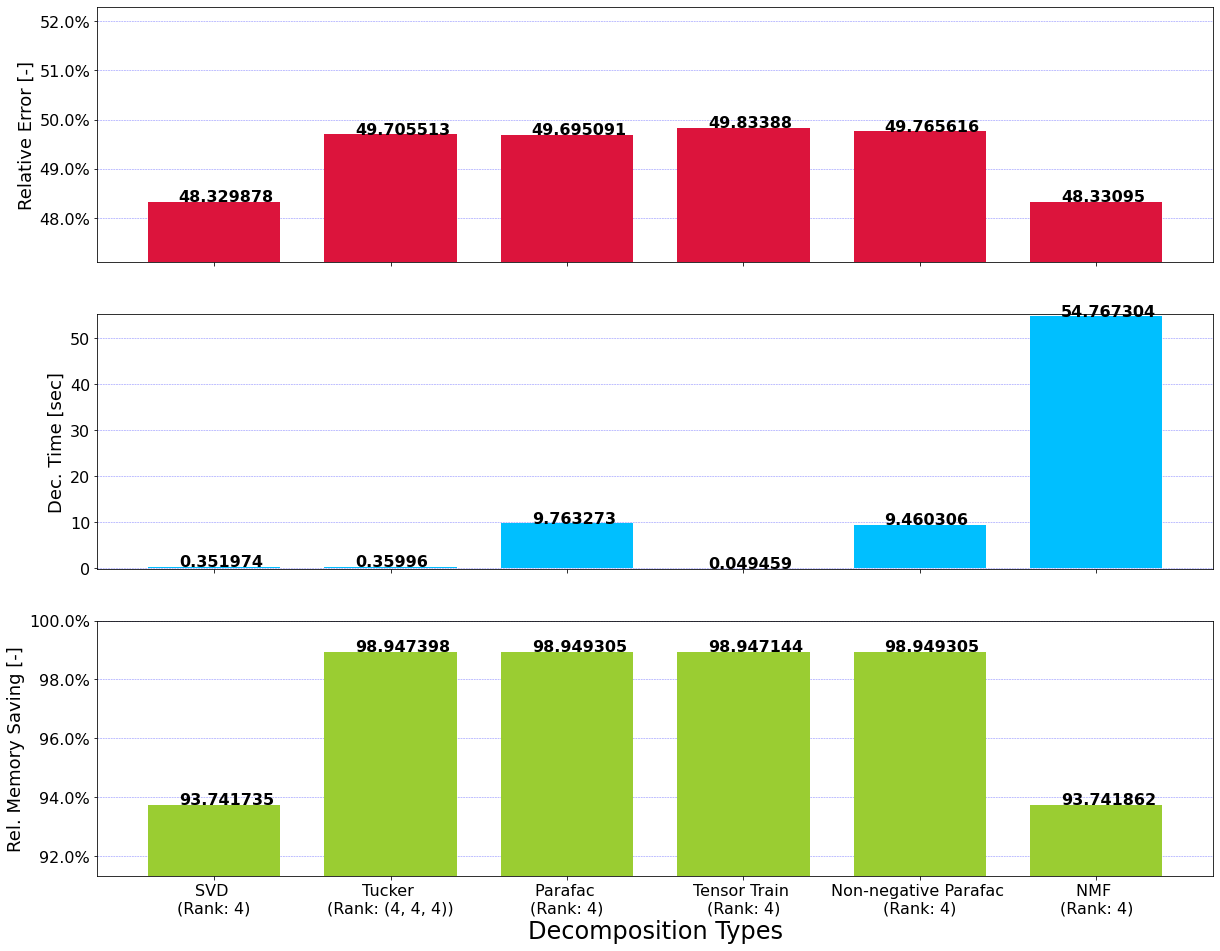

In [96]:
colors = ["crimson","deepskyblue", "yellowgreen"]
y_axis = [decErrAxis,decTimeAxis, memSavAxis ]
fig, ax = plt.subplots(3, 1, figsize=(20,16), sharex=True)

for i in range(3):
    ax[i].bar(nameAxis, y_axis[i], color=colors[i], width = .75)
    ax[i].yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    ax[i].set_axisbelow(True)
    ax[i].set_ylim(min(y_axis[i])- np.mean(y_axis[i])*0.025, max(y_axis[i])+ np.mean(y_axis[i])*0.05)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    for h, v in enumerate(y_axis[i]):
        ax[i].text(h-.20, v+.0025, str(np.round(v,6)), color='black', size = 16, weight = "bold")

plt.xlabel("Decomposition Types", fontsize=24)
ax[0].set_ylabel("Relative Error [-]", fontsize=18)
ax[1].set_ylabel("Dec. Time [sec]", fontsize=18)
ax[2].set_ylabel("Rel. Memory Saving [-]", fontsize=18)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[2].set_ylim(min(y_axis[i])- np.mean(y_axis[i])*0.025, 100)
plt.savefig('fig/SavTimeError.png')

In [ ]:
from matplotlib import ticker
uniSlightBlue = '#00BEFF'
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.bar(operList, tensorOperationTimes, color = uniSlightBlue)
ax.yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xticks(rotation=22.5)
ax.set_axisbelow(True)
ax.set_ylabel("Elapsed Time [sec]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

In [ ]:
#TODO #1
# Speed comparion is not implemented. No function definition is defined for decomposed_tensor @ Vec multiplication.

In [ ]:
#TODO #2
# For every decomposition type -> Line Plot: decomposition error, speedup time in tensor operations vs decomposed tensor operations.

In [ ]:
# DONE! (11.07.21)
# For every decomposition type -> Bar plot: Decomposition error, decomposition time, memory saving